# Evaluate the WGANGP Model

reload the WGANGP model and its training history and evaluate

## Import modules

In [2]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from wgangp_model import (
    load_generator,
    generate_synthetic_data,
    inverse_transform_synthetic_data,
)

2025-02-27 13:12:29.826906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 13:12:29.834099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 13:12:29.842394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 13:12:29.844862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 13:12:29.851268: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [4]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load dataset


In [5]:
df_path = "datasets/core_shell_particles_raw_122500.h5"
df_input = pd.read_hdf(df_path)
df_input = df_input.drop(columns=["wavelength", "Q_sca", "Q_back", "Q_fwd"], axis=1)
df_input

,mat_core,mat_shell,r_core,r_shell
0,Si,Si,1,2
1,Si,SiO2,1,2
2,Si,Au,1,2
3,Si,Ag,1,2
4,Si,Si3N4,1,2
...,...,...,...,...
122495,TiO2,Au,100,200
122496,TiO2,Ag,100,200
122497,TiO2,Si3N4,100,200
122498,TiO2,ZrO2,100,200


## Load preprocessed data

In [6]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

# Open the HDF5 file
f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

# Combine X_train and X_test
X_transformed = np.concatenate((X_train, X_test), axis=0)
print("Shape of X_transformed:", X_transformed.shape)
np.random.seed(42)
np.random.shuffle(X_transformed)
X_transformed

Shape of X_transformed: (122500, 16)


array([[ 0.2929293 ,  0.47474748,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.6262626 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.47474748,  0.03030303,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.93939394,  0.27272728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5555556 , -0.6969697 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.25252524,  0.27272728,  0.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

## Load Preprocessor

In [7]:
# Load the preprocessors and scalers
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

## Load Generator

In [9]:
# Load the pre-trained generator
generator = load_generator("models/wgangp_generator.h5")

# Generate synthetic data
num_samples = 10000
latent_dim = 128
synthetic_data = generate_synthetic_data(generator, latent_dim, num_samples)
synthetic_data

I0000 00:00:1740659158.468324   51278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740659158.470416   51278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740659158.471830   51278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740659158.572716   51278 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

[<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
 array([[ 0.4770829 ,  0.1954924 ],
        [ 0.38880047,  0.12887028],
        [ 0.84449285,  0.582358  ],
        ...,
        [-0.2824027 , -0.50134057],
        [ 0.6302455 ,  0.30188152],
        [ 0.38769236,  0.30680543]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 7), dtype=float32, numpy=
 array([[2.93307011e-07, 1.96622888e-04, 1.44573189e-02, ...,
         4.77441549e-02, 1.16659081e-04, 9.37484980e-01],
        [1.05696490e-04, 1.10182713e-03, 2.14856409e-04, ...,
         4.08226406e-05, 3.69511217e-01, 4.77224065e-04],
        [1.23046907e-02, 5.02288947e-03, 6.06908907e-05, ...,
         5.88244200e-01, 2.88846232e-02, 2.00653430e-02],
        ...,
        [7.21269018e-08, 1.11918723e-08, 9.99886274e-01, ...,
         1.45551468e-07, 1.24601655e-07, 1.13253875e-04],
        [7.64234665e-06, 7.30625834e-06, 1.03178281e-04, ...,
         6.62292987e-02, 9.91095362e-07, 9.33651567e-01],
        [6.18871081e-06, 5.2509719

In [10]:
# Inverse transform synthetic data to the original scale
synthetic_data_original_scale = inverse_transform_synthetic_data(
    preprocessor, synthetic_data
)
synthetic_data_original_scale

array([[74.1156005859375, 120.35374450683594, 'TiO2', 'Si3N4'],
       [69.7456283569336, 113.7581558227539, 'Ag', 'Si3N4'],
       [92.3023910522461, 158.6534423828125, 'Si3N4', 'Ag'],
       ...,
       [36.52106857299805, 51.367286682128906, 'Au', 'ZrO2'],
       [81.69715118408203, 130.8862762451172, 'TiO2', 'ZrO2'],
       [69.6907730102539, 131.3737335205078, 'SiO2', 'ZrO2']],
      dtype=object)

In [11]:
# Define the desired column order
desired_columns = ["mat_core", "mat_shell", "r_core", "r_shell"]
generated_columns = ["r_core", "r_shell", "mat_core", "mat_shell"]

# Convert synthetic data to a DataFrame
synthetic_df = pd.DataFrame(synthetic_data_original_scale, columns=generated_columns)

# Reorder columns according to the desired order
synthetic_df = synthetic_df[desired_columns]
synthetic_df

,mat_core,mat_shell,r_core,r_shell
0,TiO2,Si3N4,74.115601,120.353745
1,Ag,Si3N4,69.745628,113.758156
2,Si3N4,Ag,92.302391,158.653442
3,SiO2,ZrO2,45.925495,126.473709
4,Si,Si,56.487568,78.179848
...,...,...,...,...
9995,ZrO2,Au,76.545723,126.321701
9996,Ag,ZrO2,74.328667,54.113621
9997,Au,ZrO2,36.521069,51.367287
9998,TiO2,ZrO2,81.697151,130.886276


## Plotting
---

### <u> Real Data </u>

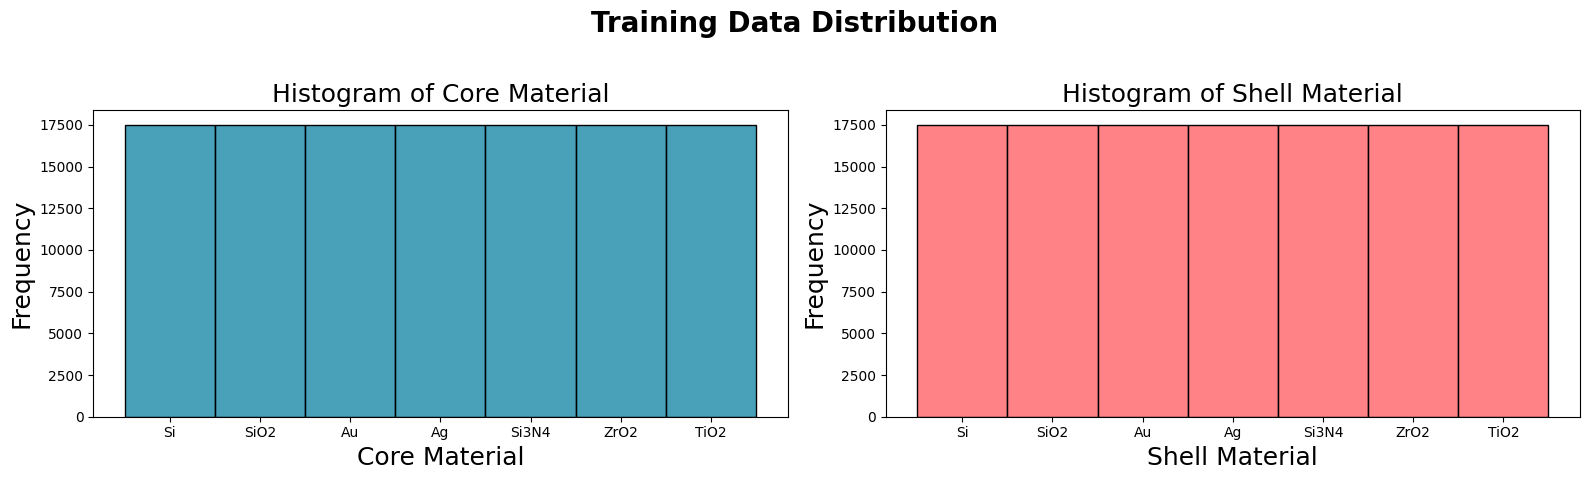

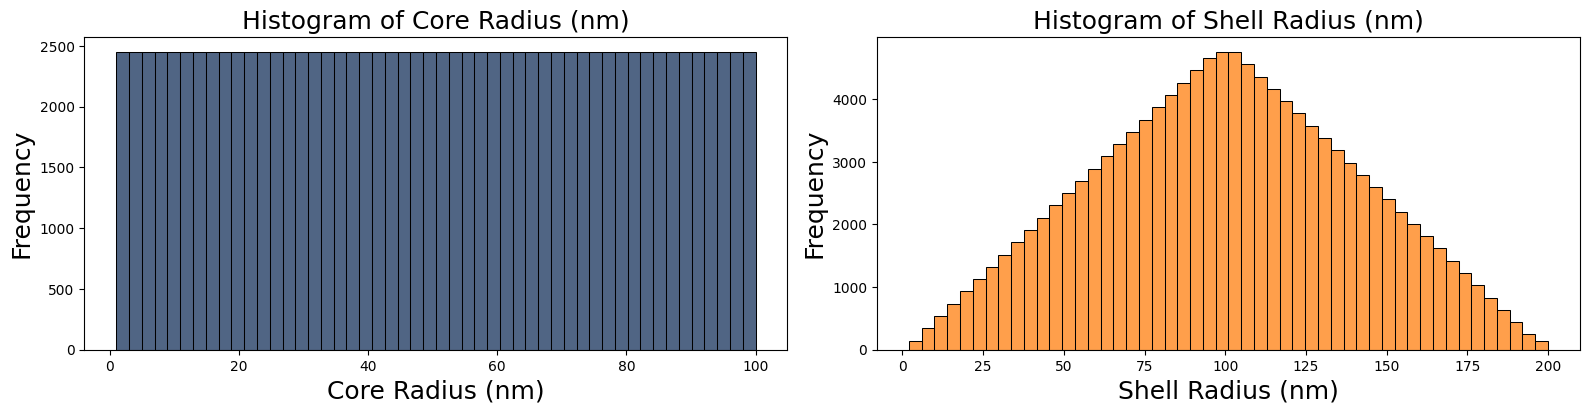

In [12]:
# Plotting histograms
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 5))  # Adjust the layout and size as needed
fig1.suptitle("Training Data Distribution", fontweight="bold", fontsize=20)

# Core Material
sns.histplot(
    df_input["mat_core"], bins=30, color="#0b81a2ff", edgecolor="black", ax=axs1[0]
)
axs1[0].set_title("Histogram of Core Material", fontsize=18)
axs1[0].set_xlabel("Core Material", fontsize=18)
axs1[0].set_ylabel("Frequency", fontsize=18)

# Shell Material
sns.histplot(
    df_input["mat_shell"], bins=30, color="#ff5a5eff", edgecolor="black", ax=axs1[1]
)
axs1[1].set_title("Histogram of Shell Material", fontsize=18)
axs1[1].set_xlabel("Shell Material", fontsize=18)
axs1[1].set_ylabel("Frequency", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plotting histograms for numerical features
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 4.6))

# Core Radius (nm)
sns.histplot(
    df_input["r_core"], bins=50, color="#16325bff", edgecolor="black", ax=axs2[0]
)
axs2[0].set_title("Histogram of Core Radius (nm)", fontsize=18)
axs2[0].set_xlabel("Core Radius (nm)", fontsize=18)
axs2[0].set_ylabel("Frequency", fontsize=18)

# Shell Radius (nm)
sns.histplot(
    df_input["r_shell"], bins=50, color="#ff7f0eff", edgecolor="black", ax=axs2[1]
)
axs2[1].set_title("Histogram of Shell Radius (nm)", fontsize=18)
axs2[1].set_xlabel("Shell Radius (nm)", fontsize=18)
axs2[1].set_ylabel("Frequency", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### <u> Synthetic Data </u>

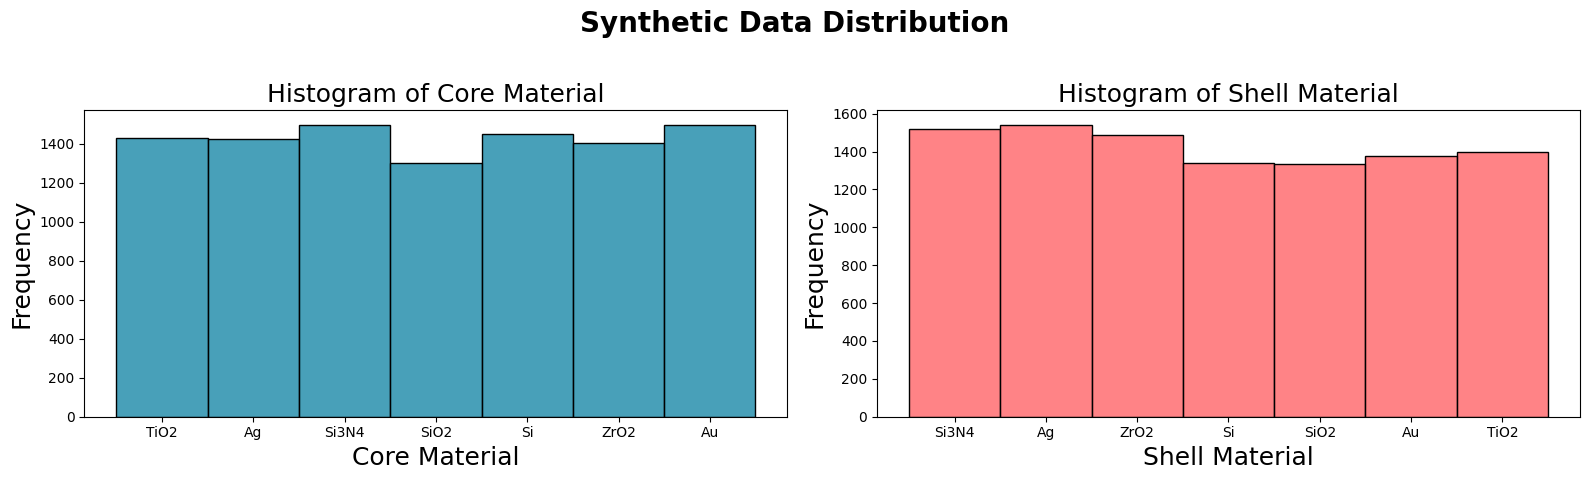

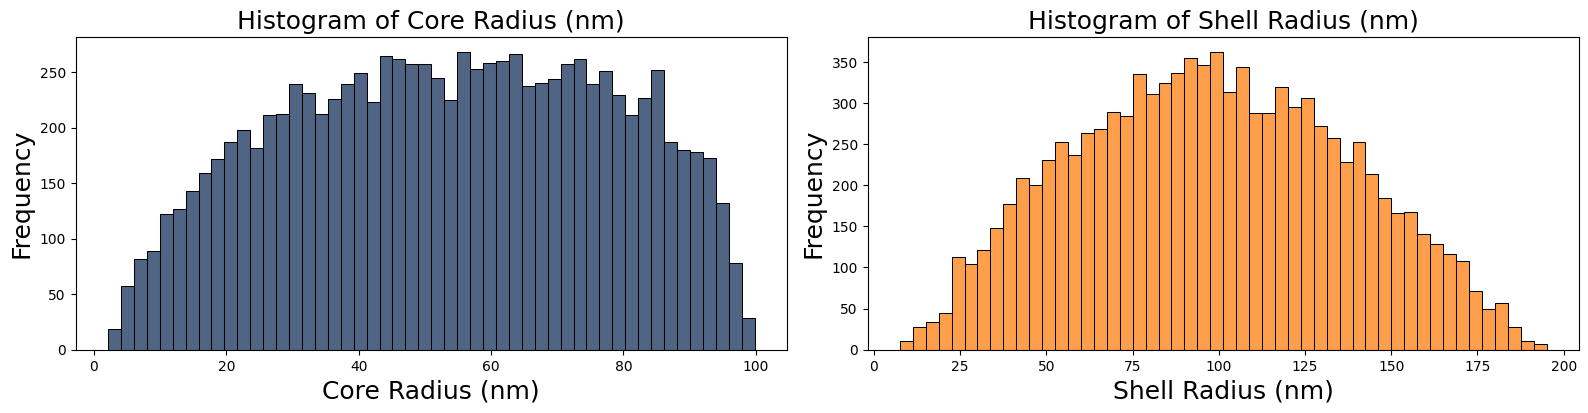

In [13]:
# Plotting histograms
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
fig1.suptitle("Synthetic Data Distribution", fontweight="bold", fontsize=20)

# Core Material
sns.histplot(
    synthetic_df["mat_core"], bins=30, color="#0b81a2ff", edgecolor="black", ax=axs1[0]
)
axs1[0].set_title("Histogram of Core Material", fontsize=18)
axs1[0].set_xlabel("Core Material", fontsize=18)
axs1[0].set_ylabel("Frequency", fontsize=18)

# Shell Material
sns.histplot(
    synthetic_df["mat_shell"], bins=30, color="#ff5a5eff", edgecolor="black", ax=axs1[1]
)
axs1[1].set_title("Histogram of Shell Material", fontsize=18)
axs1[1].set_xlabel("Shell Material", fontsize=18)
axs1[1].set_ylabel("Frequency", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plotting histograms for numerical features
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 4.6))

# Core Radius (nm)
sns.histplot(
    synthetic_df["r_core"], bins=50, color="#16325bff", edgecolor="black", ax=axs2[0]
)
axs2[0].set_title("Histogram of Core Radius (nm)", fontsize=18)
axs2[0].set_xlabel("Core Radius (nm)", fontsize=18)
axs2[0].set_ylabel("Frequency", fontsize=18)

# Shell Radius (nm)
sns.histplot(
    synthetic_df["r_shell"], bins=50, color="#ff7f0eff", edgecolor="black", ax=axs2[1]
)
axs2[1].set_title("Histogram of Shell Radius (nm)", fontsize=18)
axs2[1].set_xlabel("Shell Radius (nm)", fontsize=18)
axs2[1].set_ylabel("Frequency", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### <u> Pairwise scatter Plot </u>


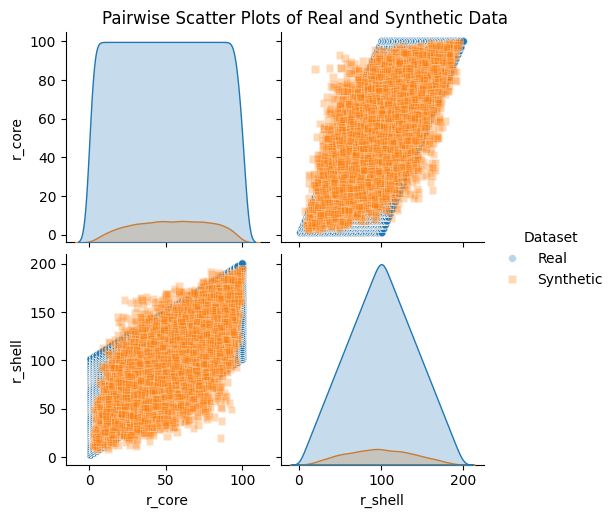

In [14]:
# Add a column to distinguish between real and synthetic data
df_input["Dataset"] = "Real"
synthetic_df["Dataset"] = "Synthetic"

combined_df = pd.concat([df_input, synthetic_df], ignore_index=True)
pairplot = sns.pairplot(
    combined_df, hue="Dataset", markers=["o", "s"], plot_kws={"alpha": 0.3, "s": 30}
)
pairplot.fig.suptitle("Pairwise Scatter Plots of Real and Synthetic Data", y=1.02)
plt.show()